# Mixtec Gender Classification

### Imports

In [17]:
%matplotlib inline

#%pip install pandas numpy torcheval torch matplotlib
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split, ConcatDataset
from torchvision import datasets, transforms

from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

torch.manual_seed(42)

### Define hardware

In [6]:
!pwd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}\n')
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

/orange/ufdatastudios/alexwebber/mixteclabeling/notebooks
Using device: cuda


NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Define path to images

In [14]:
basepath = Path('/home/alexwebber/toorange/alexwebber/mixteclabeling') # Base data directory
path_v = basepath / 'data/labeled_figures/codex_vindobonensis/gender/'
path_n = basepath / 'data/labeled_figures/codex_nuttall/gender/'
path_s = basepath / 'data/labeled_figures/codex_selden/gender/'

### Load figures into pandas, visualize

In [47]:
## Load CSV
mixtec_figures = pd.read_csv(basepath / "data/mixtec_figures.csv")

print(mixtec_figures.groupby('quality')['gender'].value_counts())
print('\n')
print(mixtec_figures['gender'].value_counts())
print('\n')
print(mixtec_figures['quality'].value_counts())


quality  gender
a        male      427
         female    220
b        male       68
         female     47
c        female      8
         male        4
Name: count, dtype: int64


gender
male      499
female    275
Name: count, dtype: int64


quality
a    647
b    115
c     12
Name: count, dtype: int64


### Load figures into datasets by codex

In [15]:
## Define image transforms
## List of transforms https://pytorch.org/vision/stable/auto_examples/plot_transforms.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((227, 227), antialias=True),
     # transforms.Grayscale(),
     # transforms.ColorJitter(contrast=0.5),
     # transforms.RandomRotation(360),     # Maybe useful for standng and sitting
     # transforms.RandomHorizontalFlip(50),
     # transforms.RandomVerticalFlip(50)
])

## Load images into PyTorch dataset
vindobonensis_dataset = datasets.ImageFolder(path_v, transform=transform)
nuttall_dataset = datasets.ImageFolder(path_n, transform=transform)
selden_dataset = datasets.ImageFolder(path_s, transform=transform)

Dataset ImageFolder
    Number of datapoints: 210
    Root location: /home/alexwebber/toorange/alexwebber/mixteclabeling/data/labeled_figures/codex_vindobonensis/gender
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
           )


### Concatenate datasets

In [19]:
figures_dataset = ConcatDataset([vindobonensis_dataset, nuttall_dataset, selden_dataset])

print(figures_dataset)

### Assign classes to map

In [20]:
class_map = {0: "female", 1: "male"}

### Print random image for sanity check

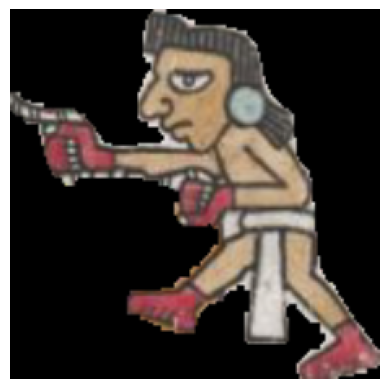

In [21]:
# Access a random image from the dataset
random_index = np.random.randint(len(figures_dataset))
image, label = figures_dataset[random_index]

# Convert the image tensor to a NumPy array and transpose it
image = image.permute(1, 2, 0)
image = image.numpy()

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

### Visualize dataloaders

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def visualise_dataloader(dl, id_to_label=None, with_outputs=True):
    
    total_num_images = len(dl.dataset)
    idxs_seen = []
    class_0_batch_counts = []
    class_1_batch_counts = []
    
    
    for i, batch in enumerate(dl):
        
        idxs = batch[0][:, 0].tolist(); print(idxs)
        classes = batch[0][:, 1]
        class_ids, class_counts = classes.unique(return_counts=True)
        class_ids = set(class_ids.tolist())
        class_counts = class_counts.tolist()

        idxs_seen.extend(idxs)

        if len(class_ids) == 2:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(class_counts[1])
        elif len(class_ids) == 1 and 0 in class_ids:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(0)
        elif len(class_ids) == 1 and 1 in class_ids:
            class_0_batch_counts.append(0)
            class_1_batch_counts.append(class_counts[0])   
        else:
            raise ValueError('More than two classes detected')
            
    if with_outputs:
        
        fig, ax = plt.subplots(1, figsize=(15, 15))

        ind = np.arange(len(class_0_batch_counts))
        width = 0.35  
    
        ax.bar(ind, class_0_batch_counts, width, label=(id_to_label[0] if id_to_label is not None else '0'))
        ax.bar(ind + width, class_1_batch_counts, width, label=(id_to_label[1] if id_to_label is not None else '1'))
        ax.set_xticks(ind, ind+1)
        ax.set_xlabel('Batch index', fontsize=12)
        ax.set_ylabel('No. of images in batch', fontsize=12)
        ax.set_aspect('equal')
    
        plt.legend()
        plt.show()
        
        num_images_seen = len(idxs_seen)
        
        print(f'Avg Proportion of {(id_to_label[0] if id_to_label is not None else "Class 0")} per batch: {(np.array(class_0_batch_counts)/10).mean()}')
        print(f'Avg Proportion of {(id_to_label[1] if id_to_label is not None else "Class 1")} per batch: {(np.array(class_1_batch_counts)/10).mean()}')
        print('=============')
        print(f'Num. unique images seen: {len(set(idxs_seen))}/{total_num_images}')
    return class_0_batch_counts, class_1_batch_counts, idxs_seen

### Split combined dataset into training and testing sets and load into DataLoaders

In [25]:
batch_size = 20

train_set, test_set = random_split(figures_dataset, [0.8, 0.2])

# FIXME
# class_counts = mixtec_figures.gender.value_counts()
# class_weights = 1/class_counts
# sample_weights = [1/class_counts[i] for i in mixtec_figures.gender.values]
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights=sample_weights, num_samples=batch_size, replacement=True)

# train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = False, sampler=sampler)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)

In [26]:
# FIXME
# class_0_batch_counts, class_1_batch_counts, idxs_seen = visualise_dataloader(train_set, 
                                                                             # {0: "Woman (Minority class)",
                                                                             #  1: "Man (Majority class)"})

In [27]:
# train_set.dataset

# Training

### Define CNN

In [28]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(16 * 56 * 56, 1568)  # Adjusted size

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 16 * 56 * 56)
        x = self.fc1(x)
        x = x.view(batch_size, -1)
        return x


# Create the model
cnn = CNN()
cnn.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
)

### Define hyperparameters

In [29]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

### Train model

In [30]:
cnn.train()
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()

        outputs = cnn(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % batch_size == 0:
            print("Epoch: " + str(epoch + 1) + " | " "Loss: " + str(running_loss))
        
            running_loss = 0.0

print('Finished Training')


Epoch: 1 | Loss: 8.005249977111816
Epoch: 1 | Loss: 55.15484219789505
Epoch: 2 | Loss: 0.5194005966186523
Epoch: 2 | Loss: 12.827910006046295
Epoch: 3 | Loss: 0.5952084064483643
Epoch: 3 | Loss: 10.11001667380333
Epoch: 4 | Loss: 0.4780929684638977
Epoch: 4 | Loss: 8.413852781057358
Epoch: 5 | Loss: 0.31010937690734863
Epoch: 5 | Loss: 8.696992367506027
Epoch: 6 | Loss: 0.3471546769142151
Epoch: 6 | Loss: 7.650866910815239
Epoch: 7 | Loss: 0.3649390637874603
Epoch: 7 | Loss: 6.763554349541664
Epoch: 8 | Loss: 0.1920679658651352
Epoch: 8 | Loss: 7.153412565588951
Epoch: 9 | Loss: 0.28081679344177246
Epoch: 9 | Loss: 6.177926152944565
Epoch: 10 | Loss: 0.15057888627052307
Epoch: 10 | Loss: 5.284963622689247
Epoch: 11 | Loss: 0.21973469853401184
Epoch: 11 | Loss: 4.711120285093784
Epoch: 12 | Loss: 0.34791964292526245
Epoch: 12 | Loss: 4.875246740877628
Epoch: 13 | Loss: 0.1757114678621292
Epoch: 13 | Loss: 3.8324685469269753
Epoch: 14 | Loss: 0.10509464889764786
Epoch: 14 | Loss: 3.56834

### View incorrectly labeled samples

In [31]:
cnn.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
)

In [34]:
for i, data in enumerate(train_loader, 0):
    images, labels = data[0].to(device), data[1].to(device)
    
    outputs = cnn(images)
    
    _, predictions = torch.max(outputs, 1)
    
    correct = 0
    total = len(predictions)
    for label, image, prediction in zip(labels, images, predictions):
        if label != prediction:
            image = image.permute(1, 2, 0)
            image = image.cpu().numpy()

            plt.imshow(image)
            plt.title("Prediction: " + class_map[prediction.item()] + " | Label: " + class_map[label.item()])
            plt.axis('off')
            plt.show()


            

### Save model

In [35]:
savepath = "../models/mixtec_gender_classifier.pth"

torch.save(cnn.state_dict(), savepath)

### Visualize learning

In [36]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/mixtec_experiment_gender')

### Define tensorboard output function

In [44]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize1
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="inferno")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

### Output sample heatmap of selected features

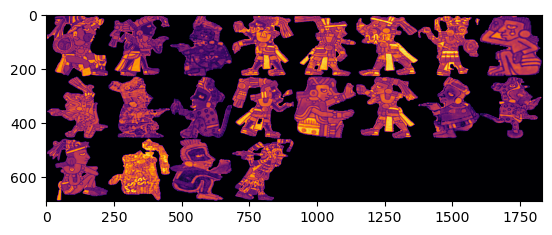

In [45]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('mixtec_genders', img_grid)

# Testing

### Load images and labels from test_loader

In [39]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

### Load model

In [40]:
cnn = CNN()
cnn.load_state_dict(torch.load(savepath))
cnn.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
)

### Produce predictions and calculate accuracy of model

In [42]:
cnn.eval()

predicted_list = []
target_list = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        target_list += labels.cpu()
        
        # calculate outputs by running images through the network
        outputs = cnn(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        print(_)
        predicted_list += predicted
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {str(len(test_set))} test images: {100 * correct // total} %')

tensor([ 60.0750,  95.3275,  89.4039,  87.4892,  83.2113,  51.2469,  71.9592,
        101.6635,  52.1180,  96.9183,  95.8511,  88.2304,  60.3115,  94.6592,
         80.2543,  83.1480,  70.4183,  83.4238,  67.9440,  98.9290],
       device='cuda:0')
tensor([ 63.8303,  93.6120,  93.8237,  85.5714,  38.1927,  63.9396,  57.6693,
        100.6571,  97.7534, 122.3549, 100.2723,  74.8810,  78.0128,  78.7493,
         98.9543, 111.6999,  83.2177,  81.2360,  84.2033, 115.2091],
       device='cuda:0')
tensor([ 88.6124,  64.1897,  86.4598,  57.9736,  56.4091,  96.3489,  36.6738,
         68.3233,  76.3772,  96.9958, 105.4687, 123.3164, 105.3414,  74.4973,
         71.9211, 100.1338,  81.8828,  73.4652,  82.3281,  67.2500],
       device='cuda:0')
tensor([ 90.2927,  83.4951,  68.9505,  89.2736,  73.5670, 108.7006,  81.3506,
        121.8982, 113.2336, 119.6403,  85.6427,  75.8300,  93.3028,  83.0158,
         85.7361,  89.7015,  75.1379, 124.3126,  77.3710, 135.0164],
       device='cuda:0')
tens

In [43]:
print(f"Predicted: {torch.tensor(predicted_list)}")
print(f"Truth    : {torch.tensor(target_list)}")

metric_names = ["Accuracy", "Precision", "Recall", "F1"]
metrics = [BinaryAccuracy(), BinaryPrecision(), BinaryRecall(), BinaryF1Score()]

for metric, name in zip(metrics, metric_names):
    metric.update(torch.tensor(predicted_list), torch.tensor(target_list))
    print(f"{name:<9}: {metric.compute()}")

Predicted: tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0])
Truth    : tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0])
Accuracy : 0.8613138794898987
Precision: 0.871287107467651